# Entregable Proyecto Python ML

In [86]:
# Basic regression to predict fuel efficiency

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pip install pandas
import seaborn as sns
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [87]:
# Create dataset
# Modify dataset

File = 'Pulsar.csv'
dataset = pd.read_csv(File, na_values='?', skipinitialspace=True)
print(dataset.isna().sum())
dataset = dataset.dropna()
dataset.drop_duplicates(inplace=True)
dataset['Class'] = dataset['Class'].map({0: 'Cold', 1: 'Hot'})
dataset = pd.get_dummies(dataset, columns=['Class'], prefix='', prefix_sep='')

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64


In [88]:
dataset.tail()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Cold,Hot
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,1,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,1,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,1,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,1,0
17897,57.062500,85.797340,1.406391,0.089520,188.306020,64.712562,-1.597527,1.429475,1,0


In [89]:
# Split the data into train and test

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(17898, 10) (14318, 10) (3580, 10)


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,14318.0,111.076718,25.667571,5.812500,100.929688,115.105469,127.046875,190.421875
SD,14318.0,46.550077,6.822899,24.772042,42.407055,46.977559,51.036918,98.778911
EK,14318.0,0.478192,1.072770,-1.738021,0.026949,0.224016,0.473819,8.069522
Skewness,14318.0,1.784499,6.277860,-1.791886,-0.190602,0.196507,0.925124,68.101622
Mean_DMSNR_Curve,14318.0,12.727913,29.632155,0.213211,1.932483,2.798077,5.470318,222.421405
SD_DMSNR_Curve,14318.0,26.406667,19.549443,7.370432,14.457645,18.470136,28.481725,110.642211
EK_DMSNR_Curve,14318.0,8.289654,4.511528,-3.139270,5.774510,8.432818,10.675133,34.539844
Skewness_DMSNR_Curve,14318.0,104.582793,106.352681,-1.976976,34.786480,83.147625,138.329061,1191.000837
Cold,14318.0,0.909834,0.286430,0.000000,1.000000,1.000000,1.000000,1.000000
Hot,14318.0,0.090166,0.286430,0.000000,0.000000,0.000000,0.000000,1.000000


In [90]:
# split features from labels
train_features = train_dataset.copy() # X train
test_features = test_dataset.copy() # X testeo

train_labels = train_features.pop('SD') # Y train
test_labels = test_features.pop('SD')   #$ Y test

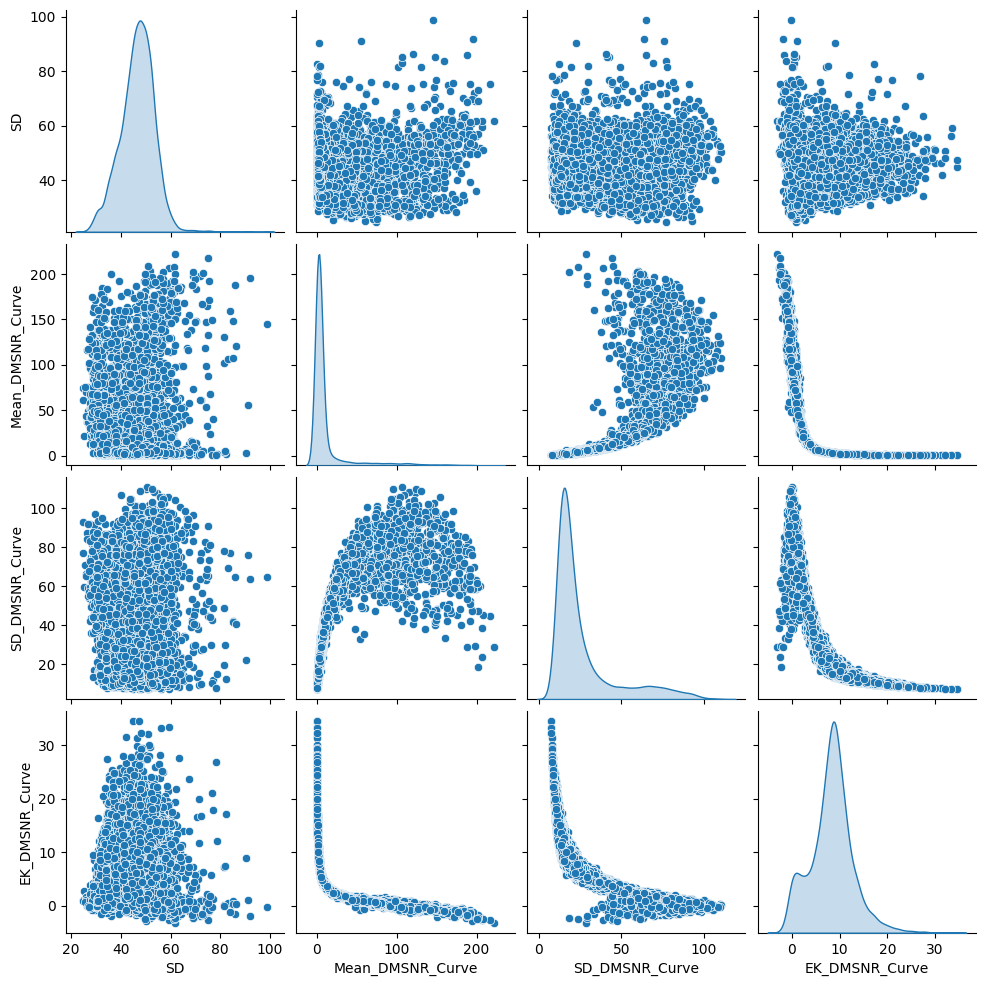

In [91]:
sns.pairplot(train_dataset[['SD', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve']], diag_kind='kde')

In [92]:
## scaler
# Normalize
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[[1.11076706e+02 4.78192329e-01 1.78449881e+00 1.27279167e+01
  2.64066582e+01 8.28965282e+00 1.04582802e+02 9.09833610e-01
  9.01662558e-02]]
[[6.5877777e+02 1.1507543e+00 3.9408760e+01 8.7800250e+02 3.8215384e+02
  2.0352470e+01 1.1310100e+04 8.2036406e-02 8.2036421e-02]]


In [93]:
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())


First example: [[102.2890625    0.23169775   0.22715643   2.27006689  14.34301971
    9.5003683  117.0577236    1.           0.        ]]
Normalized: [[-0.34237573 -0.22978202 -0.24807769 -0.3529348  -0.6171052   0.2683697
   0.11730178  0.31480482 -0.31480432]]


In [94]:
# Regression
 # 1. Normalize the input SD_DMSNR_Curve
 # 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

feature = 'SD_DMSNR_Curve'

single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(14318,) (14318, 9)


In [95]:
# Sequential model
DMSNR_Curve_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

In [96]:
DMSNR_Curve_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_12 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [97]:
# loss and optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
loss = keras.losses.MeanAbsoluteError() # MeanSquaredError J

#Learning Rate
optim = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

DMSNR_Curve_model.compile(optimizer=optim, loss=loss)

In [98]:
%%time
history = DMSNR_Curve_model.fit(
    train_features['SD_DMSNR_Curve'],
    train_labels,
    epochs=20,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/20
358/358 [==============================] - 1s 2ms/step - loss: 44.8555 - val_loss: 43.0064
Epoch 2/20
358/358 [==============================] - 1s 2ms/step - loss: 41.2777 - val_loss: 39.4263
Epoch 3/20
358/358 [==============================] - 1s 3ms/step - loss: 37.6976 - val_loss: 35.8463
Epoch 4/20
358/358 [==============================] - 1s 3ms/step - loss: 34.1175 - val_loss: 32.2663
Epoch 5/20
358/358 [==============================] - 1s 2ms/step - loss: 30.5374 - val_loss: 28.6862
Epoch 6/20
358/358 [==============================] - 1s 2ms/step - loss: 26.9573 - val_loss: 25.1061
Epoch 7/20
358/358 [==============================] - 1s 2ms/step - loss: 23.3776 - val_loss: 21.5282
Epoch 8/20
358/358 [==============================] - 1s 2ms/step - loss: 19.8115 - val_loss: 17.9900
Epoch 9/20
358/358 [==============================] - 1s 2ms/step - loss: 16.3507 - val_loss: 14.6424
Epoch 10/20
358/358 [==============================] - 1s 2ms/step - loss: 13.1118

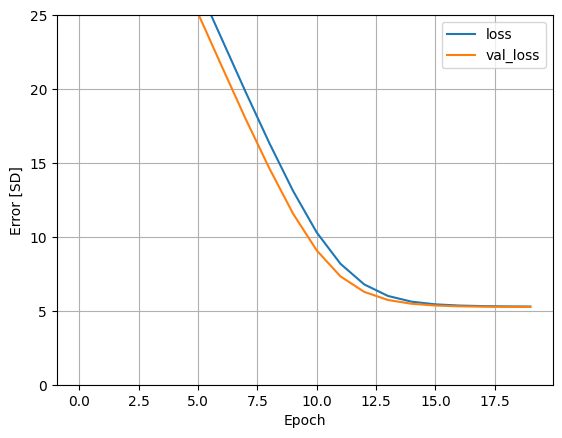

In [99]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SD]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [100]:
test_results = {}
print(test_features.shape)

test_results['DMSNR_Curve_model'] = DMSNR_Curve_model.evaluate(
    test_features['SD_DMSNR_Curve'],
    test_labels, verbose=1)

(3580, 9)
112/112 [==============================] - 0s 2ms/step - loss: 5.3400


In [111]:
# predict and plot
x = tf.linspace(0, 150, 200)
y = DMSNR_Curve_model.predict(x)

print(DMSNR_Curve_model.predict(x))

7/7 [==============================] - 0s 6ms/step
[[47.04099 ]
 [47.031307]
 [47.02162 ]
 [47.011936]
 [47.00225 ]
 [46.99257 ]
 [46.982883]
 [46.973198]
 [46.963512]
 [46.95383 ]
 [46.944145]
 [46.93446 ]
 [46.924774]
 [46.915092]
 [46.905407]
 [46.89572 ]
 [46.886036]
 [46.876354]
 [46.86667 ]
 [46.856983]
 [46.847298]
 [46.837616]
 [46.82793 ]
 [46.818245]
 [46.80856 ]
 [46.798878]
 [46.789192]
 [46.779507]
 [46.769825]
 [46.76014 ]
 [46.750454]
 [46.74077 ]
 [46.731087]
 [46.7214  ]
 [46.711716]
 [46.70203 ]
 [46.69235 ]
 [46.682663]
 [46.672977]
 [46.663292]
 [46.65361 ]
 [46.643925]
 [46.63424 ]
 [46.624554]
 [46.614872]
 [46.605186]
 [46.5955  ]
 [46.585815]
 [46.576134]
 [46.56645 ]
 [46.556763]
 [46.54708 ]
 [46.537395]
 [46.52771 ]
 [46.518024]
 [46.508343]
 [46.498657]
 [46.48897 ]
 [46.479286]
 [46.469604]
 [46.45992 ]
 [46.450233]
 [46.440548]
 [46.430866]
 [46.42118 ]
 [46.411495]
 [46.40181 ]
 [46.392128]
 [46.382442]
 [46.372757]
 [46.36307 ]
 [46.35339 ]
 [46.343704]


In [112]:
def plot_DMSNR_Curve(x, y):
  plt.scatter(train_features['SD_DMSNR_Curve'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('DMSNR_Curve_model')
  plt.ylabel('SD')
  plt.legend()

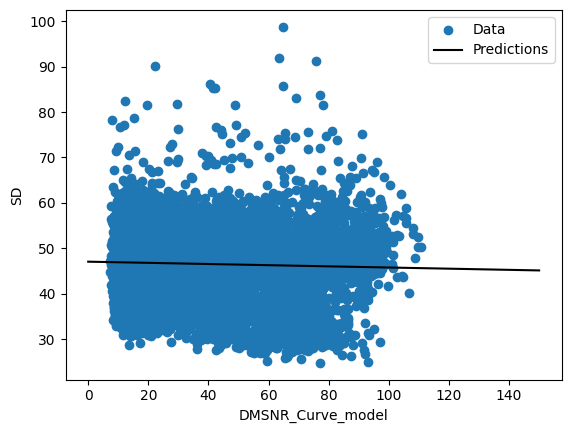

In [113]:
plot_DMSNR_Curve(x, y)

In [104]:
#save model

DMSNR_Curve_model.save('DMSNR_Curve_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
